Here we will look at transfer learning and how to use a pretrained high quaility model and change it to match our usecae. Specifcally, we will use MobileNet model form TensorFlowHub that was trained to classifiy 1001 classes, and make it so it can be used to classify two classes Cats and Dogs .
[following this collab](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c01_tensorflow_hub_and_transfer_learning.ipynb#scrollTo=s4YuF5HvpM1W)

This is a great way to leverage expert trained models on massive datasets, and to speed up learning.  [To learn how they made MobileNet use go here](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py)

In [0]:
import tensorflow as tf
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.DEBUG)

import numpy as np
import PIL.Image as Image

#### We have to resize every input image to the same size
### that was used with the pre-treined model which is 224px
IMAGE_RES = 224

import time

The pretrained model has two parts 1. Feature extractor, 2. Classifier. The feature extractor uses Conv nets and what not to detect features in the images, and the classifer part is a Dense layer that creates a probability distribution based on the features detected from the previous feature extractor part of the net. 
To reuse a pretrained model, we have to get rid of the classifier part, and replace it with our own classifier. In this case the pre-trained classifier has 1001 classes and we want 2 classes only.

In [0]:
# TensorFlowHub gives us access to the full pretrained model, or just to the feature 
# extractor for our conveniance 

# This is the full pre-trained model feature extractor + feature classifer part 
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

pretrained_model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

# this is the feature extracor part only
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

# we shouldn't train the feature extractor as it has already been trained
# and we dont wanna ruin it
feature_extractor.trainable = False

BATCH_SIZE = 32


We will split this collab into two parts.
<br>

Part 1 will be using the pretrained model as is

Part 2 will be editing it to match our cats vs dogs case

352256/352178 [==============================] - 0s 0us/step


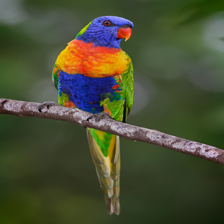

(224, 224, 3)
98304/91953 [================================] - 0s 0us/step


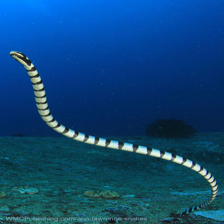

(224, 224, 3)
   8192/Unknown - 0s 0us/step

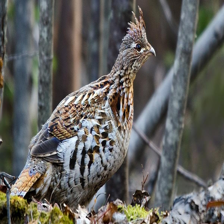

(224, 224, 3)


In [3]:
######   Part 1    #######

# here will expolore the MobileNet model and test it out

# some random images from Google matching the 1001 classes of MobileNet
rainbow_lorikeet = 'https://upload.wikimedia.org/wikipedia/commons/c/c2/Rainbow_lorikeet.jpg'
sea_snake = "https://i.pinimg.com/736x/4e/c8/c1/4ec8c11e8c0f985b1b72dd70f94c5496.jpg"
ruffed_grouse = "https://www.allaboutbirds.org/guide/assets/og/75366891-1200px.jpg"

rand_imgs = [rainbow_lorikeet, sea_snake, ruffed_grouse]

for i, url in enumerate(rand_imgs):
  img = tf.keras.utils.get_file(str(i)+".jpg", url)
  time.sleep(0.3) # wait for it to fetch
  img = Image.open(img).resize((IMAGE_RES, IMAGE_RES))
  rand_imgs[i] = img
  display(img)
  rand_imgs[i] = np.array(img)/255.0 # making the img into a normalized np array
  print(rand_imgs[i].shape)


In [4]:
# Remember, models always want a batch of images to process.
 #So here, we add a batch dimension, and pass the image to the model for prediction.
img = rand_imgs[0]
result = pretrained_model.predict(img[np.newaxis, ...])
predicted_class = np.argmax(result[0])

print('{} result shape'.format(result.shape))
print('{} the nparray image shape'.format(img.shape))
print('{} the nparray shape with np.newaxis'.format(img[np.newaxis, ...].shape))
print("{}: the np.newaxis".format(np.newaxis))
 
predicted_class # out of the 1001 classes, this is the number of the label of the prediction


(1, 1001) result shape
(224, 224, 3) the nparray image shape
(1, 224, 224, 3) the nparray shape with np.newaxis
None: the np.newaxis


91

16384/10484 [==============================================] - 0s 0us/step


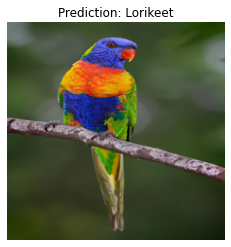

In [5]:
# decoding the prediction
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

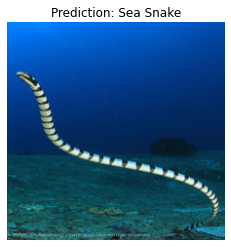

In [6]:
# we do the same for the other images 
def show_img_prediction(img):
  result = pretrained_model.predict(img[np.newaxis, ...])
  predicted_class = np.argmax(result[0])
  plt.imshow(img)
  plt.axis('off')
  predicted_class_name = imagenet_labels[predicted_class]
  _ = plt.title("Prediction: " + predicted_class_name.title())
show_img_prediction(rand_imgs[1])


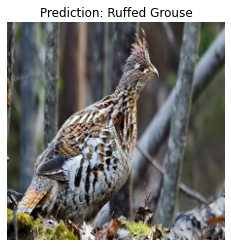

In [7]:
show_img_prediction(rand_imgs[2])


Perfect! it works!!

Now Part 2, re-purposing the model to our match our use-case, cats vs dogs

In [8]:
# this banana will split data into 80% train and 20 val
# look at this link for a guide on the splitting syntax
# https://github.com/tensorflow/datasets/blob/master/docs/splits.md
(train_examples, validation_examples ), info = tfds.load('cats_vs_dogs', with_info=True,
                                                         as_supervised=True,
                                                         split= ["train[:80%]", "train[80%:]"])
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteJINJ7O/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [9]:
# the dataset info for the curious
print(info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [0]:
# now make all the images the same size as what the pre-trained model excpects
def scale_normalize_labeled_img(img, label):
  img = tf.image.resize(img, (IMAGE_RES, IMAGE_RES))/255.0
  return img, label


train_batches = train_examples.shuffle(num_examples//4).map(
    scale_normalize_labeled_img).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_examples.map(scale_normalize_labeled_img
                                             ).batch(BATCH_SIZE).prefetch(1)

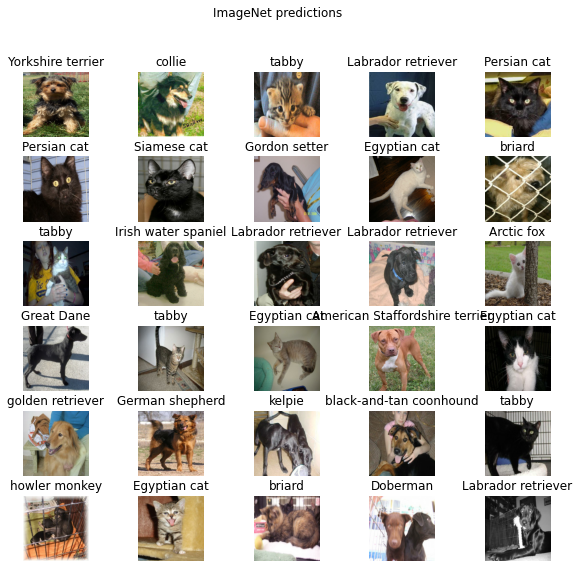

In [11]:
### Lets try to make a prediction without using our Cats vs dogs without 
#### with the pre_trained model, we see that it not only classify cats and dogs
## it tells u which bread they are.
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = pretrained_model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [12]:
## now we will use the feature extractor defined above 
# and run an image batch throught it (feature extractor not the whole pretrained model)

# we see that the batch size is 32 and the neurons are 1280
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [13]:
mix_model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

mix_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
# we already froze the pre-trained feature extractor so we just train it

mix_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = mix_model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 35s 60ms/step - loss: 0.0618 - accuracy: 0.9772 - val_loss: 0.0336 - val_accuracy: 0.9877
Epoch 2/6
582/582 [==============================] - 33s 57ms/step - loss: 0.0304 - accuracy: 0.9896 - val_loss: 0.0327 - val_accuracy: 0.9882
Epoch 3/6
582/582 [==============================] - 33s 57ms/step - loss: 0.0248 - accuracy: 0.9917 - val_loss: 0.0386 - val_accuracy: 0.9886
Epoch 4/6
582/582 [==============================] - 33s 57ms/step - loss: 0.0226 - accuracy: 0.9927 - val_loss: 0.0326 - val_accuracy: 0.9897
Epoch 5/6
582/582 [==============================] - 34s 58ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0333 - val_accuracy: 0.9903
Epoch 6/6
582/582 [==============================] - 33s 57ms/step - loss: 0.0169 - accuracy: 0.9946 - val_loss: 0.0355 - val_accuracy: 0.9895


In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

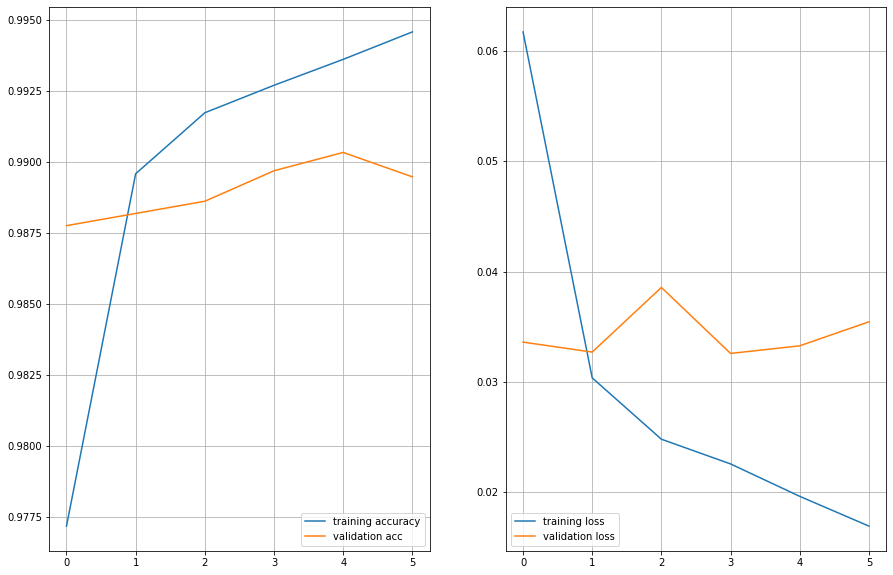

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

val_loss = history.history['val_loss']
loss = history.history['loss']
epochs_range = range (EPOCHS)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="training accuracy")
plt.plot(epochs_range, val_acc, label="validation acc")
plt.legend(loc="lower right")
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="training loss")
plt.plot(epochs_range, val_loss, label="validation loss")
plt.grid()
plt.legend(loc="lower left")


One werid thing is that the validation results are beter than the training results from the very begining, on explaintion for this is that the training prrformace is measure as average across the epoch while the validation performance is measured at the end of the epoch (end of the epoch would be better as it had the entire epoch to train right)

Another reason is that the training images are augmeted(had trasformations applied to them), which might have made them harder to classify as opposed to
the val set which as the images as is.

In [17]:
## making predictinos
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [18]:
# argmax axis https://stackoverflow.com/questions/47435526/what-is-the-meaning-of-axis-1-in-keras-argmax
predicted_batch = mix_model.predict(image_batch)
print("axis=-1 means use the last num in the shape for the argmax, see link above code")
print(predicted_batch.shape)
predicted_idx = np.argmax(predicted_batch, axis=-1)
print(predicted_idx)
predicted_class_names = class_names[predicted_idx]
predicted_class_names

axis=-1 means use the last num in the shape for the argmax, see link above code
(32, 2)
[1 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0]


array(['dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat',
       'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat',
       'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat',
       'cat', 'dog', 'dog', 'cat', 'cat'], dtype='<U3')

In [19]:
# lets compare actual labels and predicted
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_idx)

Labels:  [1 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0]
Predicted labels:  [1 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0]


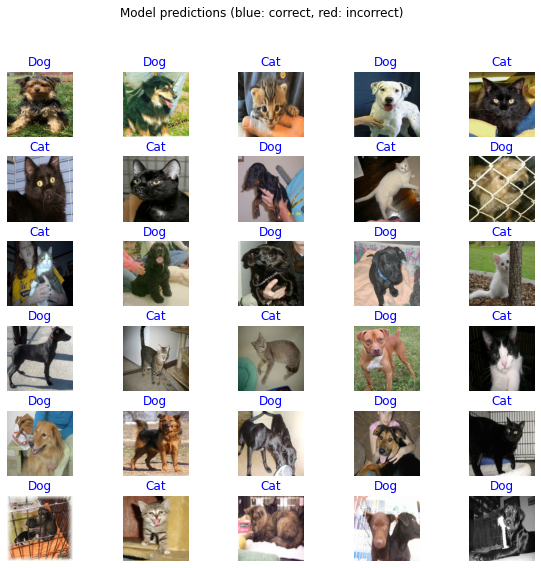

In [21]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_idx[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [23]:
## one cool trick with numpy arrays
a = np.array(['a','b'])
b = [0,1,0,1,0,1]

print(a[b])

['a' 'b' 'a' 'b' 'a' 'b']
